In [182]:
import os, re
import time
import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow_datasets as tfds
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
from IPython.display import clear_output
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from rouge import FilesRouge
# from google.colab import drive

In [183]:
# Tensorflow version
print(tf.__version__)

logging.basicConfig(level="error")
np.set_printoptions(suppress=True)

2.0.0-beta0


For Google Colaboratory

In [184]:
# drive.mount('/content/gdrive')

In [185]:
# path = "/content/gdrive/My Drive/"
# os.chdir(path)
# os.listdir(path)

## Setup input pipeline

In [186]:
output_dir = "./"
topic_vocab = os.path.join(output_dir, "topic_vocab")
abstract_vocab = os.path.join(output_dir, "abstract_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_path = os.path.join(output_dir, 'logs')

In [187]:
# Load input dataset
topic = []
dirPath = "../msc_dataset/topic/"

files = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
files = sorted(files)
for fname in files:
    if ("txt" not in fname):
        continue
    with open(dirPath+fname, "r", encoding='utf-8') as fp:
        topic.append(fp.read())

dirPath = "../ug_dataset/topic/"
files = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
files = sorted(files)
for fname in files:
    if ("txt" not in fname):
        continue
    with open(dirPath+fname, "r", encoding='utf-8') as fp:
        topic.append(fp.read())
print(len(topic))

2178


In [188]:
# The corresponding labels
abstract = []
dirPath = "../msc_dataset/abstract/"

files = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
files = sorted(files)
for fname in files:
    if ("txt" not in fname):
        continue
    with open(dirPath+fname, "r", encoding='utf-8') as fp:
        abstract.append(fp.read())
        
dirPath = "../ug_dataset/abstract/"
files = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
files = sorted(files)
for fname in files:
    if ("txt" not in fname):
        continue
    with open(dirPath+fname, "r", encoding='utf-8') as fp:
        abstract.append(fp.read())
print(len(abstract))

2178


In [189]:
data_size = len(topic)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
print(train_size)
print(test_size)

1742
436


In [190]:
# Transfer data list to tensor
examples = tf.data.Dataset.from_tensor_slices((topic, abstract))

# Split training data and testing data
train_examples = examples.take(train_size)
test_examples = examples.skip(train_size)

for top, abt in test_examples.take(3):
    print(top)
    print(abt)
    print('-' * 10)

tf.Tensor(b'Cellular Genetic Algorithms for Test Generation', shape=(), dtype=string)
tf.Tensor(b'Currently software testing is a crucial and labor-intensive component of software production. Software testing requires test data generation with good code coverage. Automated search techniques used for software test generation will be an improvement to efficiency and cost to software testing, and currently Genetic Algorithms are one the best options as a search heuristic for automated test generation.      The project will investigate in Cellular Genetic Algorithms, another subclass of Evolutionary Algorithms just like Genetic Algorithms, and their potential to replace Genetic Algorithms for test generation with even better code coverage. Research and implementation were done in regards to how these techniques may be applied to test generation, and specifically how using Cellular GAs may improve upon using standard GAs for test generation. The tests were done with the software tool Evosui

In [10]:
try:
    tokenizer_topic = tfds.features.text.SubwordTextEncoder.load_from_file(topic_vocab)
    print(f"load vocabulary： {topic_vocab}")
except:
    print("no vocabulary, start creating")
    # Create a custom subwords summary tokenizer from the training dataset.
    tokenizer_topic = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                              (top.numpy() for top, abt in train_examples), target_vocab_size=2**13)
    tokenizer_topic.save_to_file(topic_vocab)  
print(f"vocabulary size：{tokenizer_topic.vocab_size}")

try:
    tokenizer_abstract = tfds.features.text.SubwordTextEncoder.load_from_file(abstract_vocab)
    print(f"load vocabulary： {abstract_vocab}")
except:
    print("no vocabulary, start creating")
    # Create a custom subwords news tokenizer from the training dataset.
    tokenizer_abstract = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                              (abt.numpy() for top, abt in train_examples), target_vocab_size=2**13)
    tokenizer_abstract.save_to_file(abstract_vocab)
print(f"vocabulary size：{tokenizer_abstract.vocab_size}")

load vocabulary： ./topic_vocab
vocabulary size：4597
load vocabulary： ./abstract_vocab
vocabulary size：8190


Add a start and end token to the input and target.

In [11]:
def encode(to_t, ab_t):
    # tokenizer_summ.vocab_size for the <start> token
    # tokenizer_summ.vocab_size + 1 for the <end> token
    to_indices = [tokenizer_topic.vocab_size] + tokenizer_topic.encode(
                                    to_t.numpy()) + [tokenizer_topic.vocab_size + 1]
    ab_indices = [tokenizer_abstract.vocab_size] + tokenizer_abstract.encode(
                                    ab_t.numpy()) + [tokenizer_abstract.vocab_size + 1]
    return to_indices, ab_indices

Operations inside `.map()` run in graph mode and receive a graph tensor that do not have a numpy attribute. The `tokenizer` expects a string or Unicode symbol to encode it into integers. Hence, you need to run the encoding inside a `tf.py_function`, which receives an eager tensor having a numpy attribute that contains the string value.

In [12]:
def tf_encode(to_t, ab_t):
    # force 'su_t' and 'ne_t' to Eager Tensors by py_function
    return tf.py_function(encode, [to_t, ab_t], [tf.int64, tf.int64])

Note: To keep this example small and relatively fast, drop examples with a length of over MAX_LENGTH tokens.

In [13]:
MAX_LENGTH = 700
BATCH_SIZE = 64
BUFFER_SIZE = 3000

In [14]:
# def filter_max_length(to, ab, max_length=MAX_LENGTH):
#     return tf.logical_and(tf.size(to) <= max_length, tf.size(ab) <= max_length)

In [15]:
train_dataset = (train_examples  # output：(Summary, News)
                 .map(tf_encode) # output：(Summary index sequence, News index sequence)
#                  .filter(filter_max_length)
                 .cache() # speed up
                 .shuffle(BUFFER_SIZE) # random dataset
                 .padded_batch(BATCH_SIZE, # padding to same length for each batch
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # speed up

test_dataset = (test_examples
               .map(tf_encode)
#                .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [16]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [17]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


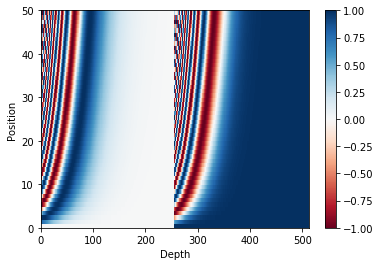

In [18]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [19]:
def create_padding_mask(seq):
    # tf.cast change data type
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [20]:
# mask the future tokens in a sequence
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """
    # scale matmul_qk
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # get seq_k sequence length
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
    # weighted average
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [22]:
# initially assign the output dimension 'd_model' & 'num_heads'
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # how many heads divided by d_model
        self.d_model = d_model # base dimension before split_heads
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads  # new dimension for each head
    
        self.wq = tf.keras.layers.Dense(d_model) 
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)  # linear transformation after concatenating heads
  
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
  
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        # divide 'd_model' into 'num_heads' depth
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # concatenate 'num_heads' depth to original dimension 'd_model'
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) 
        # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [23]:
def point_wise_feed_forward_network(d_model, dff):
  # two linear transformations for input, add ReLU activation func
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # one for sub-layer, one for layer norm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        # one for sub-layer, one for layer norm
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        # sub-layer 1: MHA
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
        # sub-layer 2: FFN
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # Masked multi-head attention (with look ahead mask and padding mask)
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        # Multi-head attention (with padding mask). 
        # V (value) and K (key) receive the encoder output as inputs. 
        # Q (query) receives the output from the masked multi-head attention sublayer.
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
        # all sub-layers output: (batch_size, target_seq_len, d_model)
        # enc_output is Encoder output sequence: (batch_size, input_seq_len, d_model)
        # attn_weights_block_1: (batch_size, num_heads, target_seq_len, target_seq_len)
        # attn_weights_block_2: (batch_size, num_heads, target_seq_len, input_seq_len)

        # sub-layer 1: Decoder layer
        attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        # sub-layer 2: Decoder layer focuses the Encoder final output
        # (batch_size, target_seq_len, d_model) (V, K, Q)
        # attention weights: the importance given to the decoder's input based on the encoder's output
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, inp_padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
        # sub-layer 3: FFN
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [26]:
class Encoder(tf.keras.layers.Layer):
    # - num_layers: how many EncoderLayers
    # - input_vocab_size: transfer index to vector
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # (input_dim, output_dim)
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # x.shape == (batch_size, input_seq_len)
        # all layer output: (batch_size, input_seq_len, d_model)
        input_seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :input_seq_len, :]

        # combine embedding and positional encoder, and regularization
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x # (batch_size, input_seq_len, d_model)

### Decoder
The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [27]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,  rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
    
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
      
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, rate)
        # FFN output logits number, represent the probability passing softmax
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        # Decoder output pass the last linear layer
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
        return final_output, attention_weights

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [29]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_topic.vocab_size + 2
target_vocab_size = tokenizer_abstract.vocab_size + 2
dropout_rate = 0.1

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 4599
target_vocab_size: 8192


## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [31]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # comput cross entropy of all position, but not sum up
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # only compute the loss of non <pad> position
  
    return tf.reduce_mean(loss_)

In [32]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # the default warmup_steps = 4000
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [34]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Supported after Tensorflow 2.0.0-beta

In [35]:
# d_models = [128, 256, 512]
# warmup_steps = [1000 * i for i in range(1, 4)]

# schedules = []
# labels = []
# colors = ["blue", "red", "black"]
# for d in d_models:
#     schedules += [CustomSchedule(d, s) for s in warmup_steps]
#     labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

# for i, (schedule, label) in enumerate(zip(schedules, labels)):
#     plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
#            label=label, color=colors[i // 3])

# plt.legend()

# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")

## Training and checkpointing

In [41]:
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate)

print(f"""Transformer has {num_layers} Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}
""")

Transformer has 4 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 4599
target_vocab_size: 8192
dropout_rate: 0.1



In [42]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [44]:
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_size}data"

checkpoint_dir = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_path, run_id)

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=20)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
  
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print(f'load the up-to-date checkpoint, the model has already trained {last_epoch} epochs.')
else:
    last_epoch = 0
    print("No checkpoint, start training.")

load the up-to-date checkpoint, the model has already trained 321 epochs.


In [45]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    # use Adam optimizer for updating parameters of Transformer
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    # the loss and training acc recorded on TensorBoard
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [46]:
# EPOCHS = 500
print(f"Transformer has already trained {last_epoch} epochs.")
#print(f"rest epochs：{min(0, last_epoch - EPOCHS)}")


# writing information on TensorBoard
summary_writer = tf.summary.create_file_writer(log_dir)


epoch = last_epoch
while(1): 
    start = time.time()
  
    # reset TensorBoard metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        #print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          #        epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    # save checkpoint for each epoch
    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    # loss and accuracy showed on TensorBoard, supported on Tensorflow 2.0.0-beta
    with summary_writer.as_default():
        tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
        tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
    epoch += 1
    if (train_loss.result() < 0.1):
        break

# 2187 data
# 150 epoch -> 29 hours
# Epoch 151 Loss 0.7426 Accuracy 0.2098

W0812 09:23:02.160223 123145330012160 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0812 09:23:02.166064 123145330012160 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0812 09:23:02.188828 123145330548736 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0812 09:23:02.192239 123145330548736 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0812 09:23:02.208520 123145330012160 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


Transformer has already trained 321 epochs.
Saving checkpoint for epoch 322 at ./checkpoints/4layers_128d_8heads_512dff_1742data/ckpt-322
Epoch 322 Loss 0.3782 Accuracy 0.2953
Time taken for 1 epoch: 1081.7677969932556 secs

Saving checkpoint for epoch 323 at ./checkpoints/4layers_128d_8heads_512dff_1742data/ckpt-323
Epoch 323 Loss 0.3708 Accuracy 0.2968
Time taken for 1 epoch: 632.9080617427826 secs

Saving checkpoint for epoch 324 at ./checkpoints/4layers_128d_8heads_512dff_1742data/ckpt-324
Epoch 324 Loss 0.3683 Accuracy 0.2953
Time taken for 1 epoch: 555.6895523071289 secs

Saving checkpoint for epoch 325 at ./checkpoints/4layers_128d_8heads_512dff_1742data/ckpt-325
Epoch 325 Loss 0.3636 Accuracy 0.2966
Time taken for 1 epoch: 569.1449019908905 secs

Saving checkpoint for epoch 326 at ./checkpoints/4layers_128d_8heads_512dff_1742data/ckpt-326
Epoch 326 Loss 0.3603 Accuracy 0.2967
Time taken for 1 epoch: 566.8436710834503 secs

Saving checkpoint for epoch 327 at ./checkpoints/4layer

KeyboardInterrupt: 

[322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365]


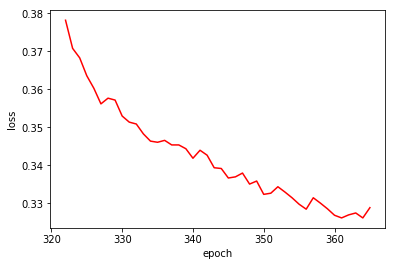

In [385]:
x = []
for i in range(322, 366):
    x.append(i)
print(x)
y = [0.3782, 0.3708, 0.3683, 0.3636, 0.3603, 0.3562, 0.3577, 0.3572, 0.3530, 0.3514, 0.3509, 0.3483, 0.3464, 
     0.3461, 0.3466, 0.3454, 0.3454, 0.3444, 0.3419, 0.3440, 0.3427, 0.3394, 0.3392, 0.3367, 0.3370, 0.3380, 
     0.3351, 0.3359, 0.3324, 0.3327, 0.3344, 0.3330, 0.3315, 0.3298, 0.3285, 0.3315, 0.3301, 0.3286, 0.3269, 
     0.3262, 0.3270, 0.3275, 0.3262, 0.3289]
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x, y, 'r-')

[322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365]


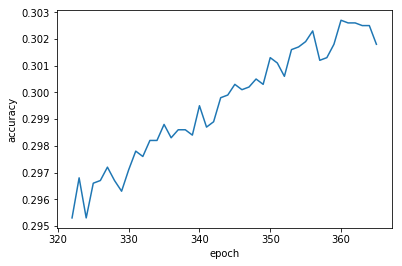

In [384]:
x = []
for i in range(322, 366):
    x.append(i)
print(x)
y = [0.2953, 0.2968, 0.2953, 0.2966, 0.2967, 0.2972, 0.2967, 0.2963, 0.2971, 0.2978, 0.2976, 0.2982, 0.2982, 
     0.2988, 0.2983, 0.2986, 0.2986, 0.2984, 0.2995, 0.2987, 0.2989, 0.2998, 0.2999, 0.3003, 0.3001, 0.3002, 
     0.3005, 0.3003, 0.3013, 0.3011, 0.3006, 0.3016, 0.3017, 0.3019, 0.3023, 0.3012, 0.3013, 0.3018, 0.3027, 
     0.3026, 0.3026, 0.3025, 0.3025, 0.3018]
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(x, y)

## Predict

In [50]:
def generation(inp_sentence):
    start_token = [tokenizer_topic.vocab_size]
    end_token = [tokenizer_topic.vocab_size + 1]
  
    inp_sentence = start_token + tokenizer_topic.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # <start> token
    decoder_input = [tokenizer_abstract.vocab_size]
    output = tf.expand_dims(decoder_input, 0)  # increase batch dimension
  
    # auto-regressive，generate one word at each time, and add into Transformer
    for i in range(MAX_LENGTH):
        # create ner masks when generating a new word
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    

        # select the last word from the seq_len dimension
        predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # return the result if the predicted_id is equal to the <end> token
        if tf.equal(predicted_id, tokenizer_abstract.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights
    
        # concatentate the predicted_id to the output which is given to the decoder as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [217]:
def print_generation(sentence):
    predicted_seq, _ = generation(sentence)

    # filter <start> & <end> tokens and turn back english tokens
    target_vocab_size = tokenizer_abstract.vocab_size
    predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
    predicted_sentence = tokenizer_abstract.decode(predicted_seq_without_bos_eos)

    print("sentence:", sentence)
    print("-" * 20)
    print("predicted_seq:", predicted_seq)
    print("-" * 20)
    print("predicted_sentence:", predicted_sentence)
    
    return predicted_sentence

In [227]:
def processing(text):
    word_punct_tokenizer = WordPunctTokenizer()
    tokens = word_punct_tokenizer.tokenize(text)
    text = " ".join(tokens)
    return text

In [228]:
def save_file(path, text):
    with open(path, 'w', encoding='utf-8') as fp:
        fp.write(text)

In [355]:
re = ""
ca = ""
count = 0
for top, abt in test_examples:
    count += 1
    print(count, top.numpy().decode("utf-8"))
    reference = processing(abt.numpy().decode("utf-8").lower())
    predict = print_generation(top.numpy().decode("utf-8").lower())
    candidate = processing(predict)
    if (candidate == '\n'):
        candidate = '[None]\n'
    if (reference == '\n'):
        reference = '[None]\n'
    re += reference + '\n'
    ca += candidate + '\n'
re = re.rstrip('\n')
ca = ca.rstrip('\n')
save_file('./reference.txt', re)
save_file('./candidate.txt', ca)

1 Cellular Genetic Algorithms for Test Generation
2 An Online Portal for the Selection and Allocation of Dissertation Projects
3 Pomorum: A Website Educating Primary Children through Experiential Methods
4 Tracking Athletes Indoors Using an iOS Application and Low Energy Bluetooth Devices
5 Using A Bio-Inspired Algorithm to Solve Multiple Travelling Salesman Problems with Online Mapping Integration
6 Exploring Human Generosity Using Social
                    NetworkingWebsite Designs and Techniques
7 Autonomous Cloud Management
8 Investigating the use of Image Classification to Aid Text
            Summarisation
9 The TWITTERATI: The Predictive Potential of Sentiment Analysis and Twitter
10 Automatic Translation from State Machines to
                    ObjectModels
11 Building a video game in Logisim
12 A Java Library for Internet Connectivity on
                    Blu-ray
13 The Domain Specificity of Sentiment Lexicons: an Investigation
14 SkyBet: Real-Time Football Team Performan

## BLEU Evaluation

In [221]:
def tokenizer(text):
    word_punct_tokenizer = WordPunctTokenizer()
    tokens = word_punct_tokenizer.tokenize(text)
    return tokens

In [360]:
scores = {'1-gram':0.0, '2-gram':0.0, '3-gram':0.0, '4-gram':0.0}
candidate_list = []
reference_list = []
with open('./candidate.txt', 'r', encoding='utf-8') as c_fp, open('./reference.txt', 'r', encoding='utf-8') as r_fp:  
    candidate_list = c_fp.readlines()
    reference_list = r_fp.readlines()
for i in range(len(candidate_list)):
    candidate = tokenizer(candidate_list[i])
    reference = [tokenizer(reference_list[i])]
    gram1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    gram2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    gram3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    gram4 = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
    scores['1-gram'] += gram1
    scores['2-gram'] += gram2
    scores['3-gram'] += gram3
    scores['4-gram'] += gram4
    print('Individual 1-gram: %f' % gram1, '2-gram: %f' % gram2, '3-gram: %f' % gram3, '4-gram: %f' % gram4)
    print('-' * 10)

Individual 1-gram: 0.328715 2-gram: 0.056429 3-gram: 0.016211 4-gram: 0.008150
----------
Individual 1-gram: 0.296748 2-gram: 0.053061 3-gram: 0.008197 4-gram: 0.000000
----------
Individual 1-gram: 0.321212 2-gram: 0.048780 3-gram: 0.006135 4-gram: 0.000000
----------
Individual 1-gram: 0.250000 2-gram: 0.047393 3-gram: 0.004762 4-gram: 0.000000
----------
Individual 1-gram: 0.320340 2-gram: 0.051659 3-gram: 0.011979 4-gram: 0.000000
----------
Individual 1-gram: 0.143491 2-gram: 0.024200 3-gram: 0.012246 4-gram: 0.008263
----------
Individual 1-gram: 0.235693 2-gram: 0.031084 3-gram: 0.007815 4-gram: 0.003930
----------
Individual 1-gram: 0.232479 2-gram: 0.054068 3-gram: 0.004541 4-gram: 0.000000
----------
Individual 1-gram: 0.244898 2-gram: 0.041096 3-gram: 0.013793 4-gram: 0.000000
----------
Individual 1-gram: 0.321429 2-gram: 0.076233 3-gram: 0.004505 4-gram: 0.000000
----------
Individual 1-gram: 0.261905 2-gram: 0.040956 3-gram: 0.006849 4-gram: 0.003436
----------
Individual

/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


 2-gram: 0.036232 3-gram: 0.007299 4-gram: 0.000000
----------
Individual 1-gram: 0.308725 2-gram: 0.081081 3-gram: 0.034014 4-gram: 0.027397
----------
Individual 1-gram: 0.365000 2-gram: 0.060302 3-gram: 0.015152 4-gram: 0.005076
----------
Individual 1-gram: 0.165300 2-gram: 0.019324 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.325148 2-gram: 0.048471 3-gram: 0.018291 4-gram: 0.000000
----------
Individual 1-gram: 0.276042 2-gram: 0.052356 3-gram: 0.005263 4-gram: 0.000000
----------
Individual 1-gram: 0.138655 2-gram: 0.033755 3-gram: 0.008475 4-gram: 0.000000
----------
Individual 1-gram: 0.283535 2-gram: 0.040016 3-gram: 0.005030 4-gram: 0.000000
----------
Individual 1-gram: 0.257669 2-gram: 0.024691 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.353846 2-gram: 0.046512 3-gram: 0.007813 4-gram: 0.000000
----------
Individual 1-gram: 0.275424 2-gram: 0.051064 3-gram: 0.017094 4-gram: 0.012876
----------
Individual 1-gram: 0.244238 2-gram: 0

/usr/local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Individual 1-gram: 0.267081 2-gram: 0.012500 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.247664 2-gram: 0.032864 3-gram: 0.009434 4-gram: 0.000000
----------
Individual 1-gram: 0.251392 2-gram: 0.044433 3-gram: 0.004477 4-gram: 0.000000
----------
Individual 1-gram: 0.194269 2-gram: 0.031421 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.260638 2-gram: 0.064171 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.197183 2-gram: 0.018868 3-gram: 0.004739 4-gram: 0.000000
----------
Individual 1-gram: 0.289976 2-gram: 0.059471 3-gram: 0.027217 4-gram: 0.016443
----------
Individual 1-gram: 0.275000 2-gram: 0.040201 3-gram: 0.015152 4-gram: 0.000000
----------
Individual 1-gram: 0.274333 2-gram: 0.037390 3-gram: 0.004698 4-gram: 0.000000
----------
Individual 1-gram: 0.161702 2-gram: 0.016998 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.047244 2-gram: 0.016575 3-gram: 0.004930 4-gram: 0.000997
----------
Individual

Individual 1-gram: 0.241028 2-gram: 0.042747 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.302564 2-gram: 0.072165 3-gram: 0.010363 4-gram: 0.000000
----------
Individual 1-gram: 0.287332 2-gram: 0.035373 3-gram: 0.008194 4-gram: 0.000000
----------
Individual 1-gram: 0.297709 2-gram: 0.019403 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.231076 2-gram: 0.052000 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.351524 2-gram: 0.057043 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.243824 2-gram: 0.028094 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.260000 2-gram: 0.030151 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.188802 2-gram: 0.023785 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.325631 2-gram: 0.058528 3-gram: 0.023565 4-gram: 0.017791
----------
Individual 1-gram: 0.269231 2-gram: 0.045161 3-gram: 0.025974 4-gram: 0.019608
----------
Individual

Individual 1-gram: 0.338383 2-gram: 0.084999 3-gram: 0.008541 4-gram: 0.000000
----------
Individual 1-gram: 0.246073 2-gram: 0.042105 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.379630 2-gram: 0.046729 3-gram: 0.018868 4-gram: 0.009524
----------
Individual 1-gram: 0.271739 2-gram: 0.043716 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.278146 2-gram: 0.020000 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.356080 2-gram: 0.060506 3-gram: 0.005069 4-gram: 0.000000
----------
Individual 1-gram: 0.196314 2-gram: 0.017574 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.191224 2-gram: 0.029177 3-gram: 0.000000 4-gram: 0.000000
----------
Individual 1-gram: 0.127559 2-gram: 0.020934 3-gram: 0.002630 4-gram: 0.000000
----------
Individual 1-gram: 0.313788 2-gram: 0.048866 3-gram: 0.013396 4-gram: 0.004489
----------
Individual 1-gram: 0.280899 2-gram: 0.067669 3-gram: 0.003774 4-gram: 0.000000
----------
Individual

In [362]:
print('The average 1-gram: %f' % (scores['1-gram']/test_size))
print('The average 2-gram: %f' % (scores['2-gram']/test_size))
print('The average 3-gram: %f' % (scores['3-gram']/test_size))
print('The average 4-gram: %f' % (scores['4-gram']/test_size))

The average 1-gram: 0.248624
The average 2-gram: 0.039748
The average 3-gram: 0.006665
The average 4-gram: 0.002312


## ROUGH Evaluation

In [365]:
files_rouge = FilesRouge('./candidate.txt', './reference.txt')
scores = files_rouge.get_scores(avg=True)
print(scores['rouge-1'])
print(scores['rouge-2'])
print(scores['rouge-l'])

{'f': 0.22464875523430824, 'p': 0.2513598973097868, 'r': 0.2171605855501095}
{'f': 0.04563144989389988, 'p': 0.05067971767843119, 'r': 0.04551025212640094}
{'f': 0.18845394001903285, 'p': 0.22351587664464667, 'r': 0.1931606002848331}
